Adrián Lillo (2025)

# Utility functions for trees

In [1]:
import itertools as it

def graph_to_LOT(G, root=0, parent=None):
    """
    Given a Graph object ``G`` that is a tree, return the corresponding
    LabelledOrderedTree rooted at ``root``.
    """
    children = []
    if G[root] == []:
        return LabelledOrderedTree(list(), label = root)
    for neighbour in sorted(G[root]):
        if neighbour != parent:
            children.append(graph_to_LOT(G, neighbour, parent=root))
    return LabelledOrderedTree(children, label = root)

def _auxiliar_digraph(code):
    """
    The auxiliar digraph defined by the word ``code``.  
    This digraph is used as means to determine the tree with a given record code.
    """
    n = len(code) + 1
    edges = []
    vertices = list([0..n])
    for i in [1..n-1]:
        edges.append((i, code[i - 1]))
    return DiGraph([vertices, edges], loops = True)

def maximum_reachable_vertex(aux, v):
    """
    The maximum vertex of the digraph ``aux`` reachable from the vertex ``v``.
    """
    max_found = 0
    for path in aux.all_simple_paths([v]):
        max_found = max(max_found, path[-1])
    return max_found

def code_records(code):
    """
    The sorted list of records of the tree with record code ``code``. 
    """
    rec = []
    aux = _auxiliar_digraph(code)
    for v in aux:
        max_reachable = maximum_reachable_vertex(aux, v)
        if max_reachable <= v and v != 0: # The root 0 is not a record by convention. 
            rec.append(v)
    return sorted(rec)

def record_decoding(code, as_graph=False):
    """
    The blob decoding of ``code``. 
    """
    n = len(code) + 1
    edges = []
    rec_list = code_records(code)

    # Add nonrecord edges
    edges += [(v, code[v - 1]) for v in [1..n] if v not in rec_list]
    
    # Add record edges 
    consecutive_records = zip(rec_list[:-1], rec_list[1:])
    for v, w in consecutive_records:
        edges.append((w, code[v-1]))
    edges.append((rec_list[0], 0))

    if as_graph:
        return Graph(edges)       
    return graph_to_LOT(Graph(edges))

def tree_records(T, current_record=0):
    """ 
    The list of records of the Cayley tree T
    """
    res = []
    label = T.label()
    if label > current_record:
        return (label,) + tuple(sum([tree_records(child, label) for child in T], tuple()))
    return tuple(sum([tree_records(child, current_record) for child in T], tuple()))

def CayleyTrees(n, as_graph=False):
    """
    Iterator for the set of Cayley trees labelled with [n]_0.
    """
    for code in it.product([0..n], repeat=n-1):
        yield record_decoding(code, as_graph)

def relabel_tree(T, relabel_map):
    """
    Relabel tree T according to map ``relabel_map``
    """
    children = [relabel_tree(child, relabel_map) for child in T]
    new_label = relabel_map(T.label()) if T.label()!= 0 else T.label()
    return LabelledOrderedTree(children=children, label=new_label)
    
def parent_map(T):
    """
    A dictionary representing the parent map of T. 
    """
    f = {child.label(): T.label() for child in T}
    for child in T:
        f |= parent_map(child)
    return f

def record_plot(T, rec_color="#6666FF", nrec_color="#FF6666", **kwargs):
    """
    Plot of the Cayley tree ``T`` using different colors for records and nonrecords.
    """
    rec = tree_records(T)
    nrec = [v for v in T.labels() if v not in rec]
    return T.to_undirected_graph().plot(
        tree_root = 0,
        layout = "tree",
        tree_orientation = "down",
        vertex_colors = {rec_color : rec, nrec_color: nrec},
        **kwargs
    )

# Weary Parking 

## From Cayley trees to parking functions

In [2]:
def get_fastest_unblocked(T_list):
    min_found = T_list[0]
    for T in T_list[1:]:
        if T.label() < min_found.label():
            min_found = T
    return min_found

def parking_outcome(T):
    to_visit = list(T)
    res = []
    while to_visit != []:
        visiting = get_fastest_unblocked(to_visit)
        to_visit.remove(visiting)
        res.append(visiting.label())
        to_visit += list(visiting)
    return Permutation(res) 

def priority_tree(T):
    pv = parking_outcome(T)
    return relabel_tree(T, pv.inverse())

def preference_sequence(T):
    outc_inv = parking_outcome(T).inverse()
    n = len(parking_outcome(T))
    pmap = parent_map(T)
    pi = []
    for i in [1..n]:
        if pmap[i] == 0:
            pi.append(1)
        else:
            pi.append(outc_inv(pmap[i]) + 1)
    return ParkingFunction(pi)

### Example

A Cayley tree T:


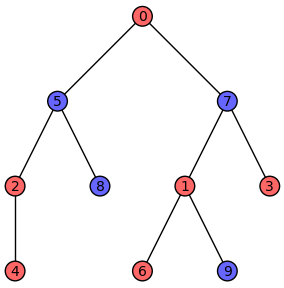

Priority tree of T


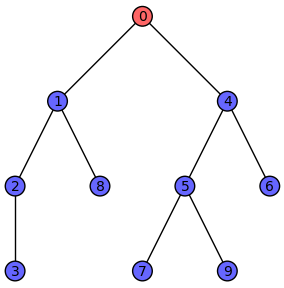

Parking outcome of T: [5, 2, 4, 7, 1, 3, 6, 8, 9]
Preference sequence of T: [5, 2, 5, 3, 1, 6, 1, 2, 6]


In [3]:
T = record_decoding([7, 5, 7, 2, 0, 1, 5, 1])

print("A Cayley tree T:")
record_plot(T).show(figsize=4)
print("Priority tree of T")
record_plot(priority_tree(T)).show(figsize=4)
print(f"Parking outcome of T: {parking_outcome(T)}")
print(f"Preference sequence of T: {preference_sequence(T)}")

## From parking functions to Cayley trees 

In [3]:
def priority_vector(pf):
    cars = pf.cars_permutation()
    pv = [pf(cars(ind)) for ind in [1..len(pf)]]
    return pv

def arrival_tree(pf):
    code = [x-1 for x in priority_vector(pf)[1:]]
    return record_decoding(code)

def parking_tree(pf):
    res = relabel_tree(arrival_tree(pf), pf.cars_permutation())
    return res 

### Example

A parking function pi: [5, 2, 5, 3, 1, 6, 1, 2, 6]
Priority vector of pi: [1, 2, 3, 1, 5, 5, 6, 2, 6]
Bird's eye permutation of pi: [5, 2, 4, 7, 1, 3, 6, 8, 9]
Parking tree of pi:


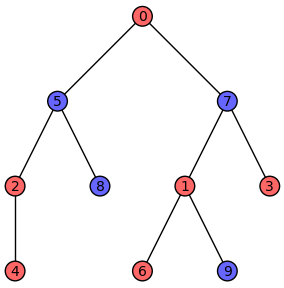

In [4]:
pf = ParkingFunction([5, 2, 5, 3, 1, 6, 1, 2, 6])
print(f"A parking function pi: {pf}")
print(f"Priority vector of pi: {priority_vector(pf)}")
print(f"Bird's eye permutation of pi: {pf.cars_permutation()}")
print(f"Parking tree of pi:")
record_plot(parking_tree(pf)).show(figsize=4)

## Verify bijection

In [5]:
for n in [1..6]:
    for pf in ParkingFunctions(n):
        assert pf == preference_sequence(parking_tree(pf))
    for T in CayleyTrees(n):
        assert T == parking_tree(preference_sequence(T))

# Statistics 

## Statistics in parking Functions

In [6]:
from collections import Counter

def ones(pf):
    return sum(1 for x in pf if x==1)

def probes(pf):
    return pf.jump() + len(pf)

def permutation_records(sigma):
    rec = []
    max_found = 0
    for x in sigma:
        if x >= max_found:
            rec.append(x)
            max_found = x
    return tuple(sorted(rec))

def pf_records(pf):
    return permutation_records(pf.cars_permutation())

def multiplicity_sequence(pf):
    n = len(pf)
    mult = [0]*(n + 1)
    count = Counter(pf)
    for key, val in count.items():
        mult[val] +=1
    mult[0] = n - sum(mult[1:]) + 1
    return tuple(mult)

### Example

In [7]:
pf = ParkingFunction([5, 2, 5, 3, 1, 6, 1, 2, 6])

print(f"pi = {pf}")
print(f"ones(pi) = {ones(pf)}")
print(f"probes(pi) = {probes(pf)}")
print(f"Rec(pi) = {pf_records(pf)}")
print(f"mult(pi) = {multiplicity_sequence(pf)}")

pi = [5, 2, 5, 3, 1, 6, 1, 2, 6]
ones(pi) = 2
probes(pi) = 23
Rec(pi) = (5, 7, 8, 9)
mult(pi) = (5, 1, 4, 0, 0, 0, 0, 0, 0, 0)


## Statistics in Cayley Trees

In [8]:
def tree_records(T, current_record=0):
    res = []
    label = T.label()
    if label > current_record:
        return (label,) + tuple(sum([tree_records(child, label) for child in T], tuple()))
    return tuple(sorted(sum([tree_records(child, current_record) for child in T], tuple())))

def diff(T, parent=0): 
    return T.label() - parent +  sum(diff(child, parent=T.label()) for child in T) 

def wait(T):
    return diff(priority_tree(T))

def edges(T):
    return [(child.label(), T.label()) for child in T] + sum((edges(child) for child in T), [])

def edge_small_ascents(T):
    return [i for (i, j) in edges(T) if j == i - 1]

def priority_small_ascents(T):
    return edge_small_ascents(priority_tree(T))

def root_degree(T):
    return len(T)

def children_sequence(T):
    chseq = [0]*len(T.labels())
    for subtree in T.subtrees():
        chseq[len(subtree)] += 1
    return tuple(chseq)

### Example

T =


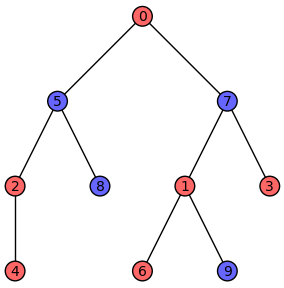

ones(pi) = 2
probes(pi) = 23
Rec(pi) = (5, 7, 8, 9)
mult(pi) = (5, 1, 4, 0, 0, 0, 0, 0, 0, 0)
[1, 2, 4, 5]


In [9]:
T = record_decoding([7, 5, 7, 2, 0, 1, 5, 1])

print(f"T =")
record_plot(T).show(figsize=4)

print(f"ones(pi) = {ones(pf)}")
print(f"probes(pi) = {probes(pf)}")
print(f"Rec(pi) = {pf_records(pf)}")
print(f"mult(pi) = {multiplicity_sequence(pf)}")
print(f"diff(pi) = {

pf = preference_sequence(T)
print(pf.lucky_cars())

## Equidistribution of statistics

### Statistics that are preserved by the bijection

In [11]:
for n in [1..6]:
    for pf in ParkingFunctions(4):
        T = parking_tree(pf)
        assert pf_records(pf) == tree_records(T)
        assert probes(pf) == wait(T)
        assert pf.luck() == len(priority_small_ascents(T))
        assert ones(pf) == root_degree(T)
        assert multiplicity_sequence(pf) == children_sequence(T)
    for T in CayleyTrees(4):
        assert children_sequence(T) == multiplicity_sequence(preference_sequence(T))

### Generating functions

#### Polynomial Ring

In [12]:
def get_variable_names(n):
    res = ['y', 'z', 't', 'q']
    for i in [1..n]:
        res.append('x'+str(i))
        res.append('w'+str(i-1))
    return res

n = 6
R = PolynomialRing(QQ, names=get_variable_names(30)) # More than enough variables
R.inject_variables()

Defining y, z, t, q, x1, w0, x2, w1, x3, w2, x4, w3, x5, w4, x6, w5, x7, w6, x8, w7, x9, w8, x10, w9, x11, w10, x12, w11, x13, w12, x14, w13, x15, w14, x16, w15, x17, w16, x18, w17, x19, w18, x20, w19, x21, w20, x22, w21, x23, w22, x24, w23, x25, w24, x26, w25, x27, w26, x28, w27, x29, w28, x30, w29


#### Parking function g.f. 

In [13]:
def pf_get_monomial(pf):
    cy = probes(pf)
    cz = pf.luck()
    ct = ones(pf)
    cq = len(pf)
    
    record_monomial = 1
    for r in pf_records(pf):
        record_monomial*=R('x'+str(r))

    multiplicity_monomial=1
    for ind, m in enumerate(multiplicity_sequence(pf)):
        multiplicity_monomial*=R('w'+str(ind))^m
    return record_monomial * y^cy * z^cz * t^ct * q^cq * multiplicity_monomial

def pf_statistics_generating_function(n): 
    return sum(pf_get_monomial(pf) for pf in ParkingFunctions(n))
    
pf_statistics_generating_function(2)

y^3*z*t^2*q^2*x1*w0^2*x2*w2 + y^2*z^2*t*q^2*x1*w0*x2*w1^2 + y^2*z^2*t*q^2*w0*x2*w1^2

In [14]:
def tree_get_monomial(T):
    cy = wait(T)
    cz = len(priority_small_ascents(T))
    ct = len(T)
    cq = len(T.labels()) - 1

    record_monomial = 1
    for r in tree_records(T):
        record_monomial*=R('x'+str(r))

    mult_monomial = 1
    for ind, m in enumerate(children_sequence(T)):
        mult_monomial *= R('w'+str(ind))^m
        
    return record_monomial * y^cy * z^cz * t^ct * q^cq * mult_monomial

def tree_statistics_generating_function(n):
    return sum(tree_get_monomial(pf) for pf in CayleyTrees(n))

tree_statistics_generating_function(2)

y^3*z*t^2*q^2*x1*w0^2*x2*w2 + y^2*z^2*t*q^2*x1*w0*x2*w1^2 + y^2*z^2*t*q^2*w0*x2*w1^2

#### Check equality of generating functions

In [15]:
for n in [1..6]:
    assert pf_statistics_generating_function(n) == tree_statistics_generating_function(n)